#Calculate the MFI (Mean Fluorescence Intensity)
In order to determine the phenotypes of each segmented cell, we compute the mean intensity of each phenotypic marker for every cell. The arcsinh transformation with a cofactor is applied to the MFIs, then the batch effect is corrected using the ComBat algorithm, and finally the data are standardized

## Importation librairies et fonctions

In [1]:
%pip install scanpy
%pip install anndata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 12.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from tqdm.auto import tqdm
from PIL import Image

from scipy.stats import f_oneway
import anndata as ad
import scanpy as sc
from scipy.stats import f_oneway
import cv2
from tqdm.auto import tqdm
import skimage as ski
from skimage import measure
from pathlib import Path
from PIL import Image
from matplotlib import cm
from IPython.display import clear_output
from google.colab import drive
import matplotlib
from sklearn.preprocessing import StandardScaler
import sklearn as skl
import seaborn as sns
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/these/"


Mounted at /content/gdrive


In [3]:
def normalize(img):
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  return img
def normalize_255(img):
  img=((img-np.min(img))/(np.max(img)-np.min(img)))*255
  return img

# Calculation of MFIs
From the marker images for each ROI of the slide, the MFI of the pixels within each cell is computed using the CSV file

In [4]:
import os
path = "/content/gdrive/MyDrive"
bool_exist=False
while bool_exist==False:
 name_path = input("Enter the path where the project has been be created (if the project is in 'My Drive' just write the name of the project): ")
 path += "/"+name_path + "/"
 bool_exist=os.path.isdir(path)
 if bool_exist==False:
   print("❌ The path does not exist")
 else:
  print("✅ Project :"+path)
  bool_exist=True

path_img_raw=path+"images/raw/"
path_mask_cell=path+"segmentation/segmentation_cells/mask_filtered/"

if os.path.isdir(path_img_raw)==False:
   print("❌ You have not completed the first step of creating PNG images")
elif os.path.isdir(path_mask_cell)==False:
   print("❌ You have not completed the first step of cells segmentation")
else:
 path_clust=path+"clustering/"
 if os.path.isdir(path_clust)==False:
     os.mkdir(path_clust)
     print("✅ Folder for clustering created")
 path_clust_mfi=path_clust+"MFI/"
 if os.path.isdir(path_clust_mfi)==False:
     os.mkdir(path_clust_mfi)
     print("✅ Folder for MFI created")
 path_clust_mfi_raw=path_clust_mfi+"Raw/"
 if os.path.isdir(path_clust_mfi_raw)==False:
     os.mkdir(path_clust_mfi_raw)
     print("✅ Folder for MFI Raw created")
 path_segmentation_df=path+"segmentation/segmentation_cells/df_ROI/"
 if os.path.isdir(path_segmentation_df)==False:
     os.mkdir(path_segmentation_df)
     print("✅ Folder for segmentation created")
algo=input("Enter the algorithm used for segmentation: ")
if os.path.isdir(path_mask_cell+algo):
  print(f"✅ {algo} will be choosen for the calcul of MFI")
  path_mask_cell=path_mask_cell+algo+"/"
else:
  print("❌ this algorithm does not exist")


Enter the path where the project has been be created (if the project is in 'My Drive' just write the name of the project): these/pipeline/VAA
✅ Project :/content/gdrive/MyDrive/these/pipeline/VAA/
Enter the algorithm used for segmentation: mesmer
✅ mesmer will be choosen for the calcul of MFI


## Dataframe with cells features and MFI for each ROI
This code block creates a DataFrame for each biopsy image containing the different characteristics of the segmented cells such as size, centroid, area...

In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.measure import regionprops_table
from tqdm import tqdm

# ==============================
# 1. Paramètres généraux
# ==============================


# Nom de la colonne contenant l'ID du label dans les DataFrames
LABEL_COL = "label"  # par cohérence avec ton screenshot

# ==============================
# 2. Liste pour le DataFrame global
# ==============================

# Chaque df_object (une biopsie / ROI) sera ajouté à cette liste
list_df_all_cells = []

# ==============================
# 3. Boucle principale sur les masques
# ==============================

list_mask_files = [
    f for f in os.listdir(path_mask_cell)
    if f.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg"))
]

for mask_file in tqdm(list_mask_files, desc="Traitement des masques / ROI"):

    # -----------------------
    # 3.1 Chargement du masque
    # -----------------------
    mask_path = os.path.join(path_mask_cell, mask_file)
    try:
        mask = np.array(Image.open(mask_path)).astype(np.int32)
    except Exception as e:
        print(f"[ERREUR] Masque introuvable ou illisible pour {mask_file} : {e}")
        continue

    if mask.ndim > 2:
        mask = mask[..., 0]

    if mask.max() == 0:
        print(f"[AVERTISSEMENT] Aucun label non nul dans {mask_file}, on passe.")
        continue

    # -----------------------
    # 3.2 Construction du DataFrame des objets
    # -----------------------
    props = regionprops_table(
        mask,
        properties=("label", "equivalent_diameter_area", "centroid", "area"),
    )
    df_object = pd.DataFrame(props)  # label, equivalent_diameter_area, centroid-0, centroid-1, area

    # Colonne "coord" (liste de coordonnées des pixels de l'objet, sous forme de chaîne)
    coords_col = []
    max_id = int(mask.max())
    for lab in df_object[LABEL_COL].astype(int):
        ys, xs = np.where(mask == lab)
        coord_str = ";".join(f"{x},{y}" for x, y in zip(xs, ys))
        coords_col.append(coord_str)
    df_object["coord"] = coords_col

    # Colonne ROI = nom du masque (sans extension)
    roi_name = os.path.splitext(mask_file)[0]
    df_object["ROI"] = roi_name

    # Aplat du masque pour les calculs de MFI
    flat_mask = mask.flatten()
    max_id = int(mask.max())

    # ---------------------------------------
    # 3.3 Dossier contenant les images marqueurs
    # ---------------------------------------
    marker_folder = os.path.join(path_img_raw, roi_name)
    if not os.path.isdir(marker_folder):
        print(f"[AVERTISSEMENT] Dossier d'images manquant pour {mask_file} : {marker_folder}")
        # On enregistre quand même le CSV des propriétés morpho, sans MFI
        out_path = os.path.join(path_clust_mfi_raw, roi_name + ".csv")
        df_object.to_csv(out_path, index=False)
        # On ajoute malgré tout ce df_object au pool global
        list_df_all_cells.append(df_object)
        continue

    # ====================
    # 3.4 Boucle sur marqueurs
    # ====================
    for file_marker in os.listdir(marker_folder):
        if not file_marker.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue

        img_path = os.path.join(marker_folder, file_marker)
        try:
            img = np.array(Image.open(img_path)).astype(np.float32)
        except Exception as e:
            print(f"[ERREUR] Impossible d'ouvrir l'image {file_marker} pour {mask_file} : {e}")
            continue

        if img.ndim > 2:
            img = img[..., 0]

        img_flat = img.flatten()
        marker = os.path.splitext(file_marker)[0]

        # ------------------------------
        # 3.4.1 Calcul vectorisé des MFI
        # ------------------------------
        sums = np.bincount(flat_mask, weights=img_flat, minlength=max_id + 1)
        counts = np.bincount(flat_mask, minlength=max_id + 1)

        means = np.zeros(max_id + 1, dtype=np.float32)
        nonzero = counts > 0
        means[nonzero] = sums[nonzero] / counts[nonzero]

        # ------------------------------
        # 3.4.2 Affectation par ID de label
        # ------------------------------
        means_series = pd.Series(means)
        df_object[marker] = df_object[LABEL_COL].map(means_series)

    # ====================
    # 3.5 Sauvegarde du CSV par ROI
    # ====================
    out_path = os.path.join(path_clust_mfi_raw, roi_name + ".csv")
    try:
        df_object_clean = df_object.dropna()
        df_object_clean.to_csv(out_path, index=False)
        print(f"✅ Sauvegardé : {out_path}")
    except Exception as e:
        print(f"[ERREUR] Sauvegarde impossible pour {mask_file} : {e}")

    # ====================
    # 3.6 Ajout au pool global
    # ====================
    list_df_all_cells.append(df_object_clean)

# ==============================
# 4. Construction du DataFrame global
# ==============================

if len(list_df_all_cells) > 0:
    df_all_cells = pd.concat(list_df_all_cells, ignore_index=True)

    out_all = os.path.join(path_clust_mfi, "df_mfi_tot_raw.csv")
    try:
        df_all_cells.to_csv(out_all, index=False)
        print(f"\n✅ DataFrame global sauvegardé : {out_all}")
        print(f"Nombre total de cellules : {len(df_all_cells)}")
    except Exception as e:
        print(f"[ERREUR] Sauvegarde du DataFrame global impossible : {e}")
else:
    print("\n[AUCUNE DONNÉE] Aucun DataFrame cellule n'a été généré.")

print(f"\n✅ Tous les fichiers CSV (par biopsie + global) sont disponibles dans : {path_clust_mfi_raw}")


Traitement des masques / ROI:   5%|▌         | 1/20 [00:49<15:46, 49.83s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351a.csv


Traitement des masques / ROI:  10%|█         | 2/20 [01:24<12:11, 40.65s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351bb.csv


Traitement des masques / ROI:  15%|█▌        | 3/20 [01:56<10:24, 36.76s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351c.csv


Traitement des masques / ROI:  20%|██        | 4/20 [02:41<10:39, 39.99s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351d.csv


Traitement des masques / ROI:  25%|██▌       | 5/20 [03:09<08:55, 35.70s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351e.csv


Traitement des masques / ROI:  30%|███       | 6/20 [03:57<09:17, 39.84s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351f.csv


Traitement des masques / ROI:  35%|███▌      | 7/20 [04:49<09:30, 43.89s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/19U07351g.csv


Traitement des masques / ROI:  40%|████      | 8/20 [05:31<08:41, 43.48s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U01680a.csv


Traitement des masques / ROI:  45%|████▌     | 9/20 [06:00<07:06, 38.76s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U01680b.csv


Traitement des masques / ROI:  50%|█████     | 10/20 [06:57<07:24, 44.44s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U01680c.csv


Traitement des masques / ROI:  55%|█████▌    | 11/20 [07:28<06:02, 40.33s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U01680d.csv


Traitement des masques / ROI:  60%|██████    | 12/20 [08:23<05:59, 44.91s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U01680e.csv


Traitement des masques / ROI:  65%|██████▌   | 13/20 [09:22<05:42, 48.98s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212a.csv


Traitement des masques / ROI:  70%|███████   | 14/20 [10:38<05:43, 57.27s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212b.csv


Traitement des masques / ROI:  75%|███████▌  | 15/20 [12:16<05:47, 69.56s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212c.csv


Traitement des masques / ROI:  80%|████████  | 16/20 [12:49<03:54, 58.58s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212d.csv


Traitement des masques / ROI:  85%|████████▌ | 17/20 [13:57<03:04, 61.37s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212e.csv


Traitement des masques / ROI:  90%|█████████ | 18/20 [14:36<01:49, 54.60s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U04212f.csv


Traitement des masques / ROI:  95%|█████████▌| 19/20 [16:44<01:16, 76.55s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U06040a.csv


Traitement des masques / ROI: 100%|██████████| 20/20 [18:03<00:00, 54.16s/it]

✅ Sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/20U06040b.csv



✅ DataFrame global sauvegardé : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/df_mfi_tot_raw.csv
Nombre total de cellules : 93211

✅ Tous les fichiers CSV (par biopsie + global) sont disponibles dans : /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/Raw/


## Batch effect assessment
This code block is used to evaluate the presence of batch effects in the dataset

In [6]:
path_batch_effect=path_clust+"MFI/batch_effect/"
if os.path.isdir(path_batch_effect)==False:
    os.mkdir(path_batch_effect)
    print("✅ Folder for batch effect created")

✅ Folder for batch effect created


In [7]:
df_mfi=pd.read_csv(path_clust_mfi+"df_mfi_tot_raw.csv")
df_mfi=df_mfi.drop(["area","centroid-0","centroid-1","coord","equivalent_diameter_area"],axis=1)
df_mfi.head()

,label,ROI,80ArAr,127I,131Xe,134Xe,138Ba,CD38,Ki67,Vimentin,...,WT1,ColT4,DNA,PanKerat,CD15,PD1,SMA,Mercure,Plomb,IgG
0,5,19U07351a,12566.373,86.111190,129.72176,61.724876,0.497983,0.373718,0.055599,2.574780,...,1.749396,2.227598,725.97784,5.170626,1.881951,2.162324,17.643002,1.746705,4.809782,0.911882
1,6,19U07351a,12640.579,92.810660,131.89067,62.889145,0.739459,0.338349,0.218134,15.753172,...,2.280322,4.216239,964.25190,18.948042,2.881947,2.931211,6.106355,1.674988,4.824940,1.392733
2,8,19U07351a,12569.162,90.300910,128.45445,62.542603,1.014640,0.503045,0.165579,6.313564,...,1.630679,2.014527,715.59020,4.322050,1.566820,1.706904,7.885904,2.294808,3.812945,0.806452
3,9,19U07351a,12594.119,90.716606,128.66647,63.650314,0.340614,0.096774,0.000000,1.366807,...,1.832697,4.554718,275.66034,2.306403,0.942875,1.025478,8.384796,1.585109,4.481205,1.047839
4,10,19U07351a,12585.801,87.562840,130.45580,60.940643,0.595372,0.251408,0.089641,2.224281,...,2.247639,0.326010,636.64710,3.824432,1.671986,1.151583,2.373060,1.757392,4.269692,0.880910


Using 93211 cells and 49 markers after dropping NaNs.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


PCA variance explained (PC1, PC2): 18.57%, 8.57%


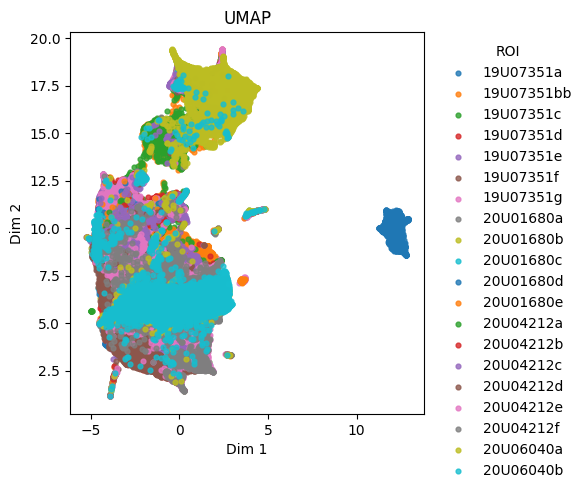

/tmp/ipython-input-3404076571.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[g for g in groups if np.sum(y == g) > 0], showfliers=False)
/tmp/ipython-input-3404076571.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[g for g in groups if np.sum(y == g) > 0], showfliers=False)
/tmp/ipython-input-3404076571.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[g for g in groups if np.sum(y == g) > 0], showfliers=False)
/tmp/ipython-input-3404076571.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been re

✅ Folder with reduction of dimension and ANOVA boxplot: /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/batch_effect/


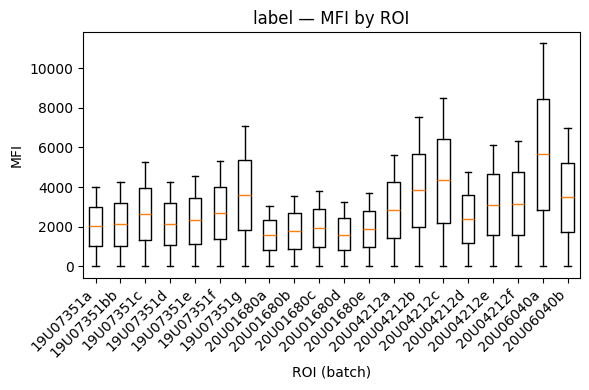

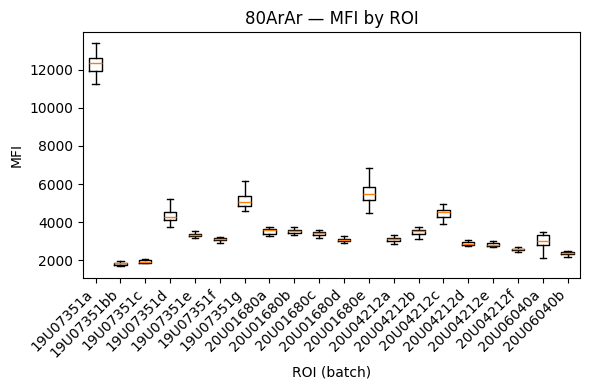

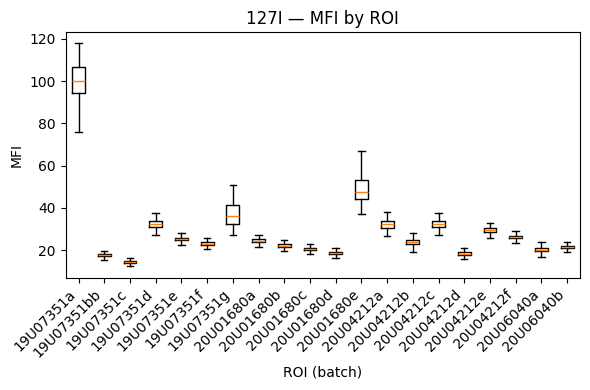

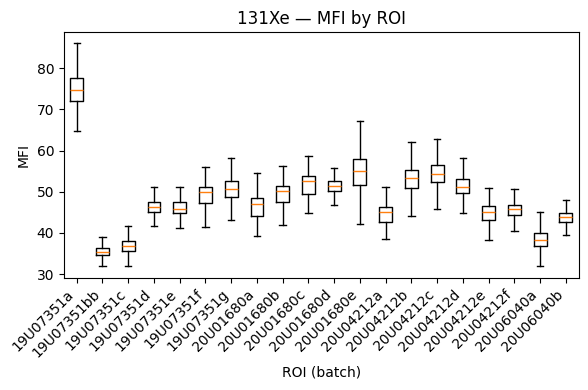

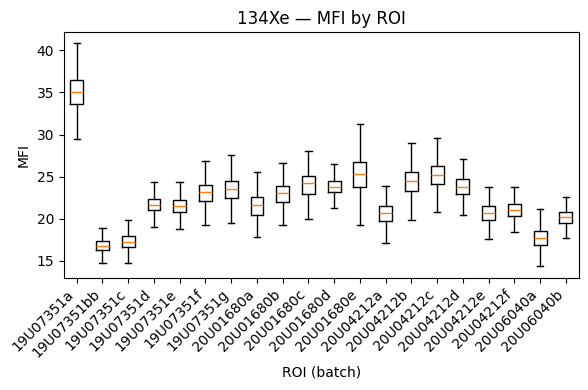

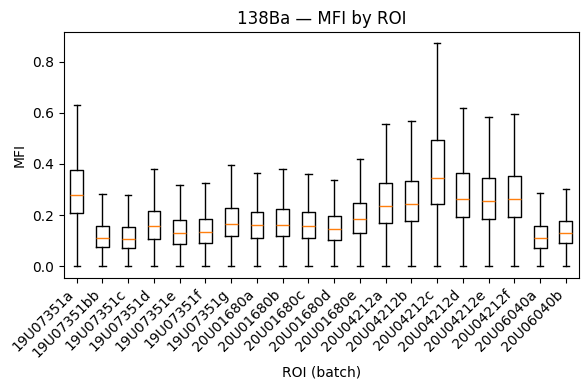

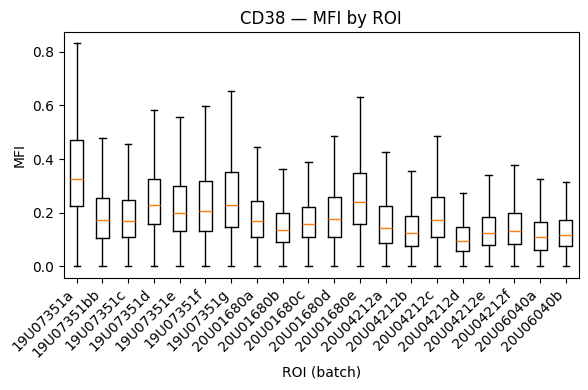

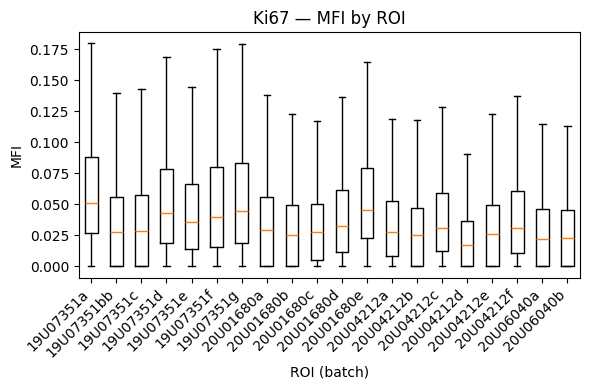

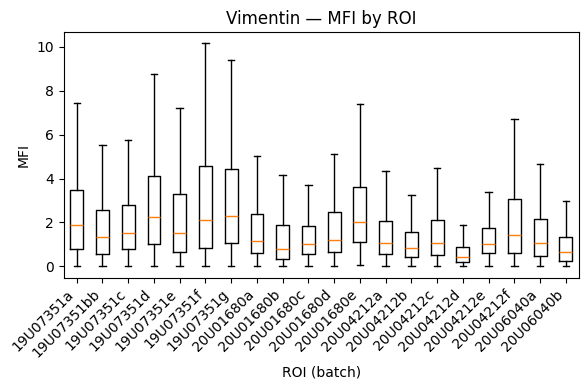

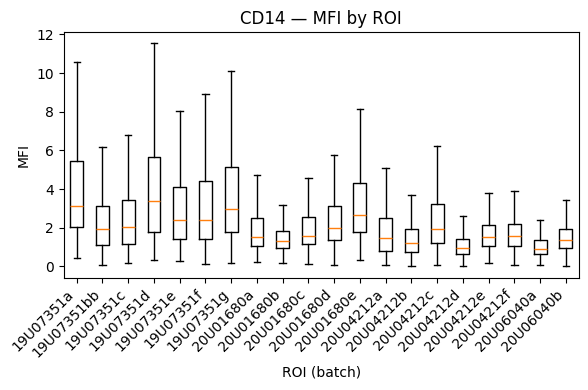

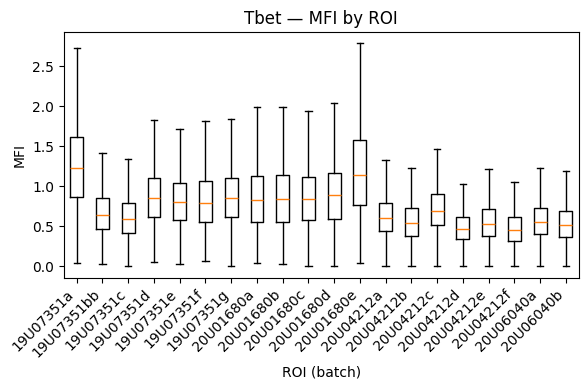

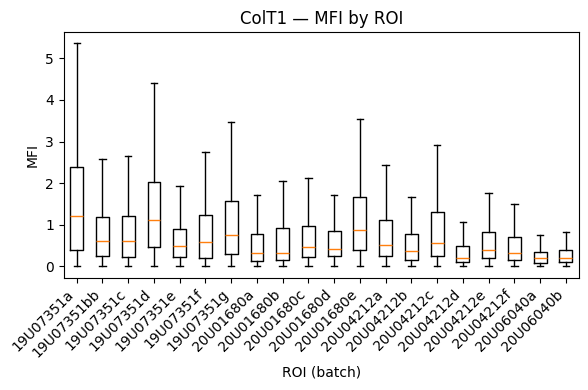

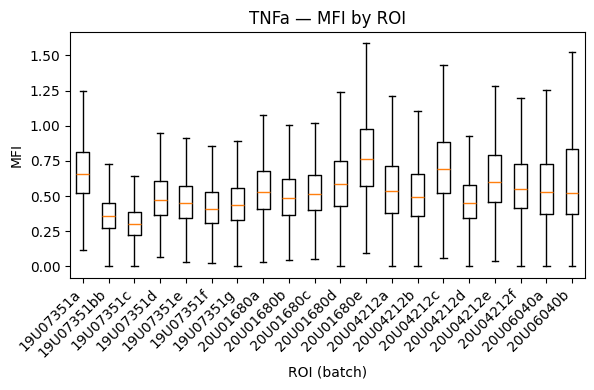

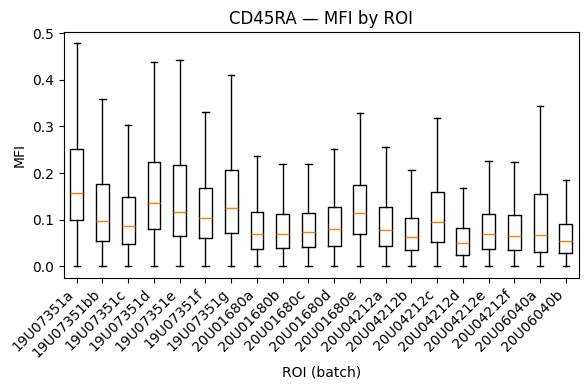

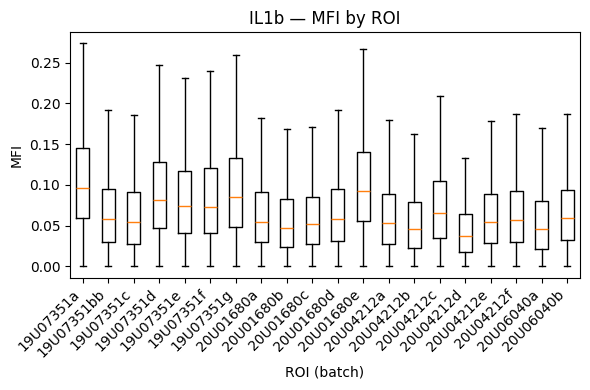

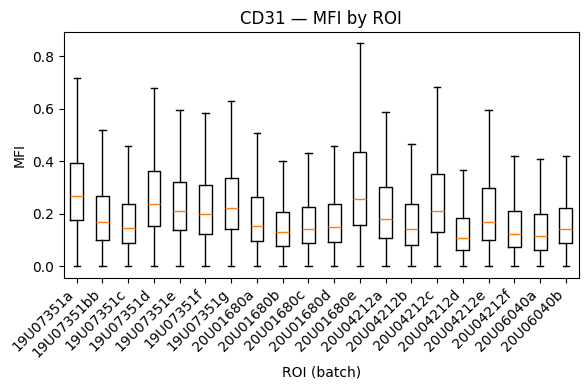

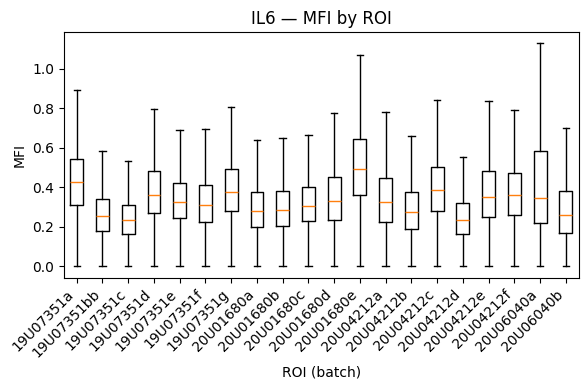

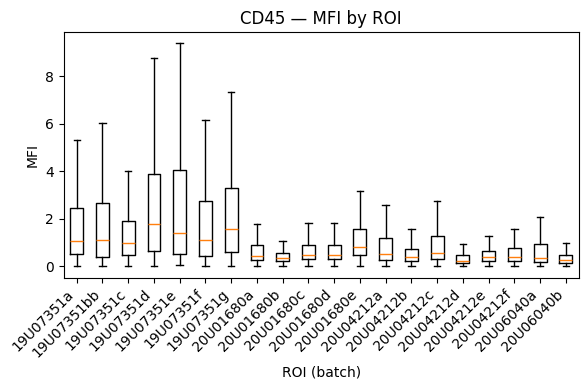

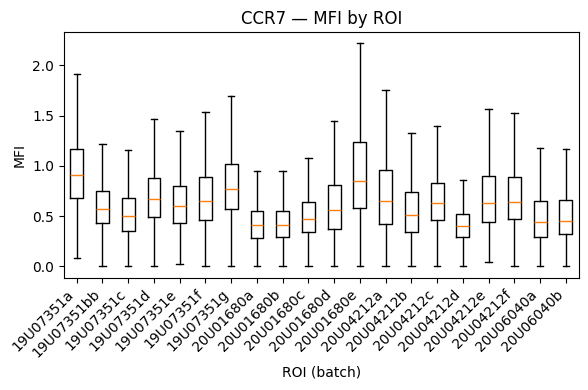

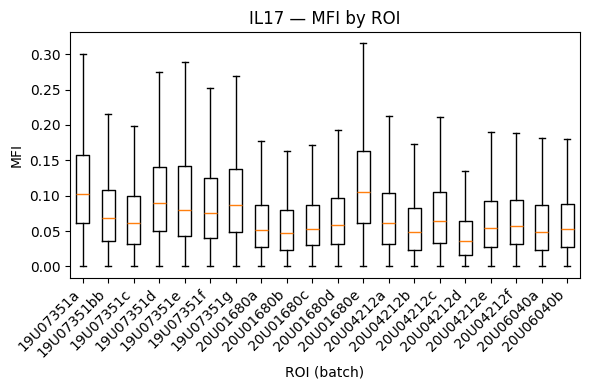

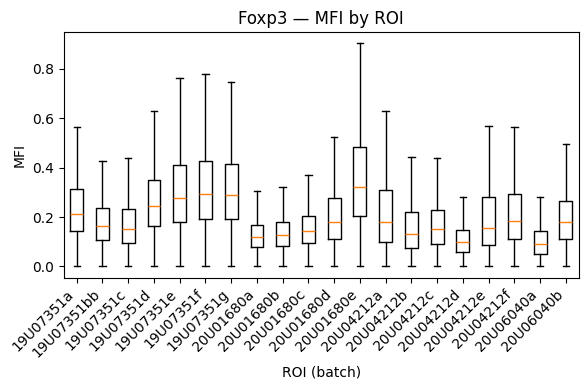

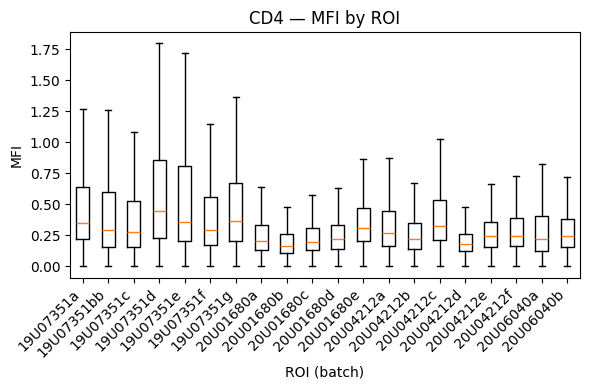

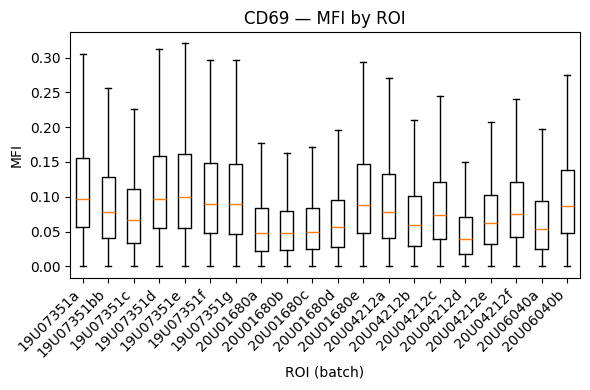

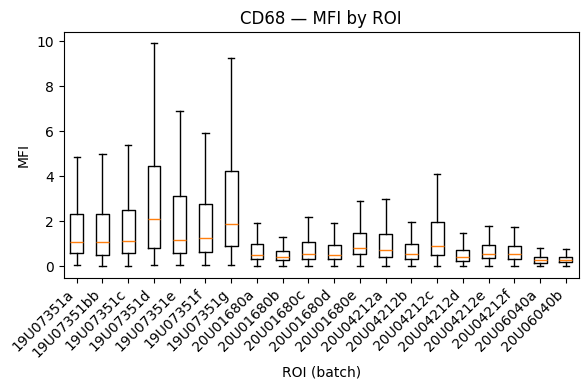

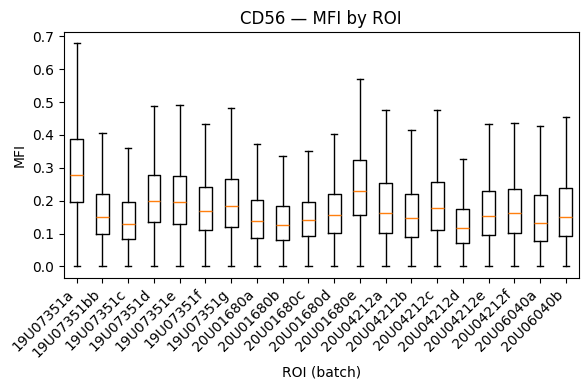

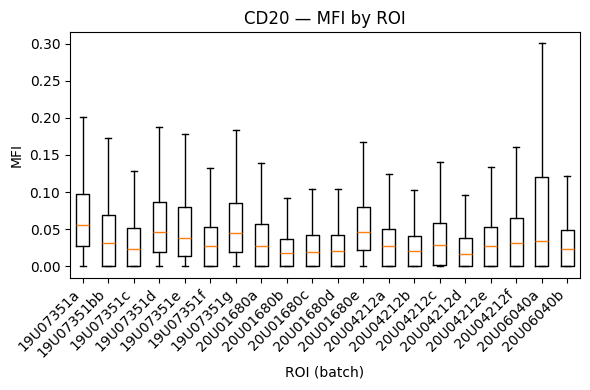

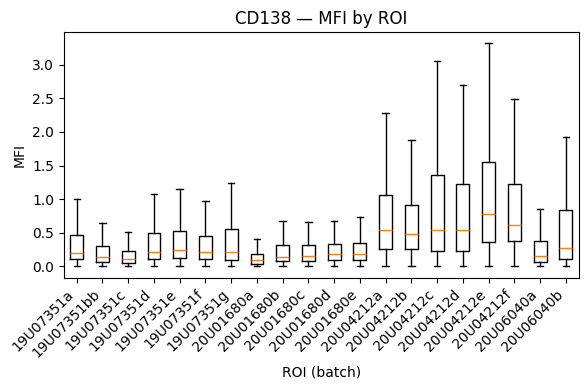

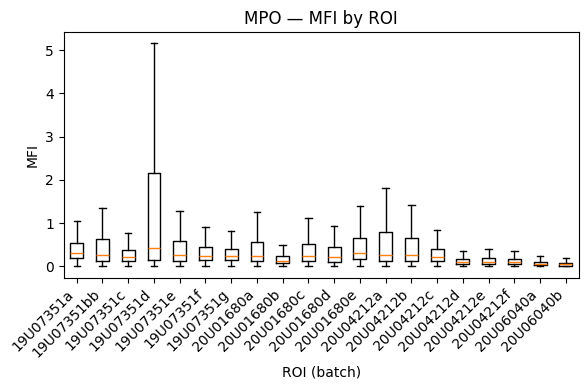

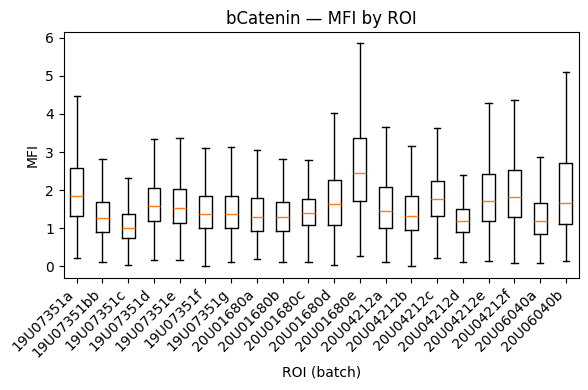

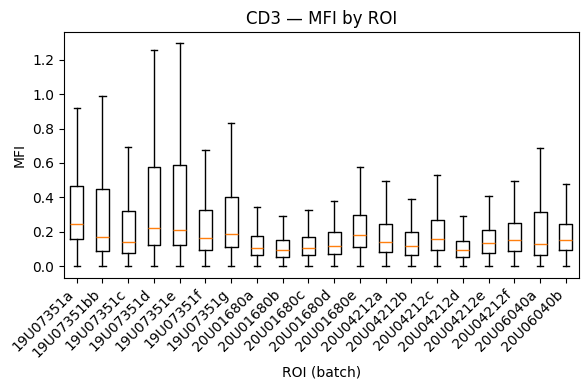

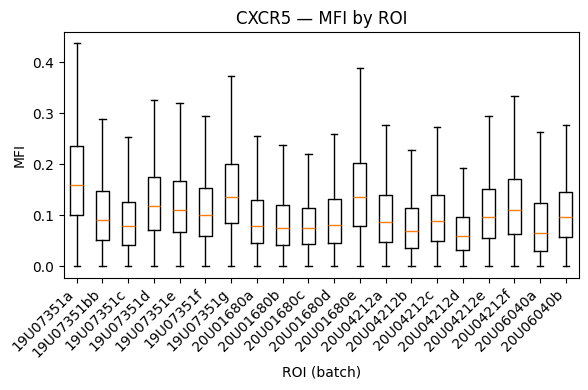

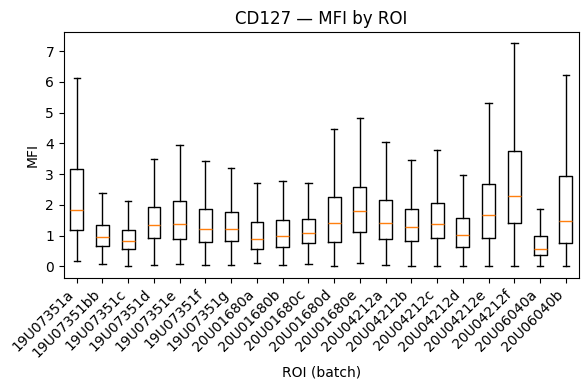

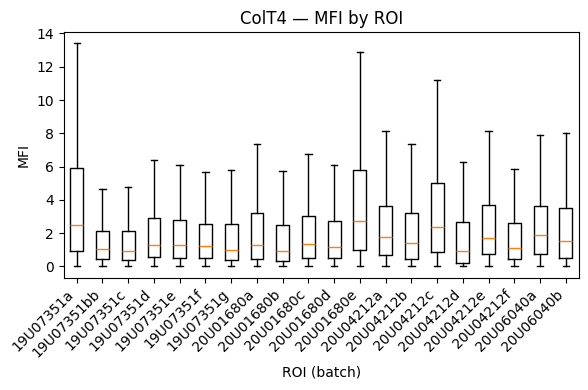

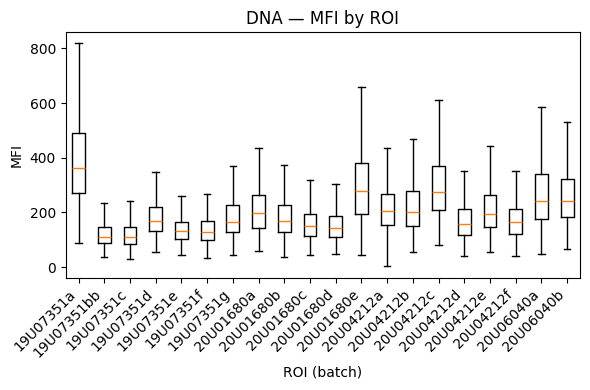

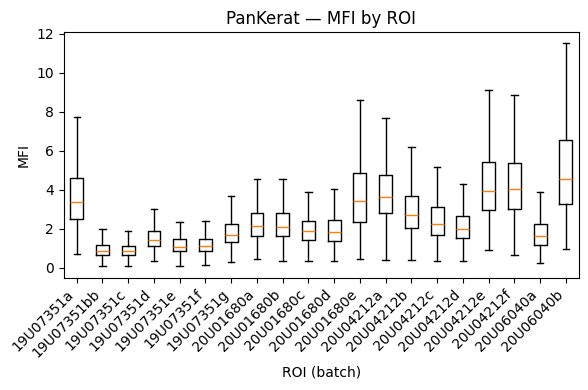

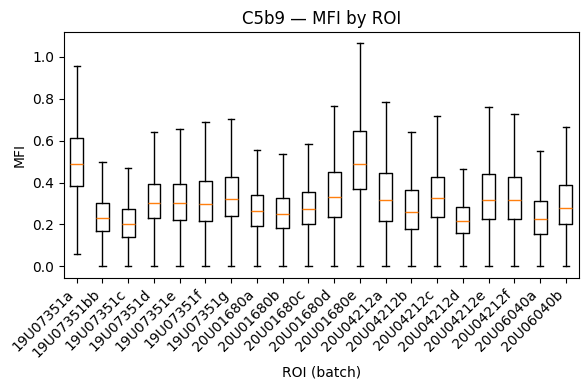

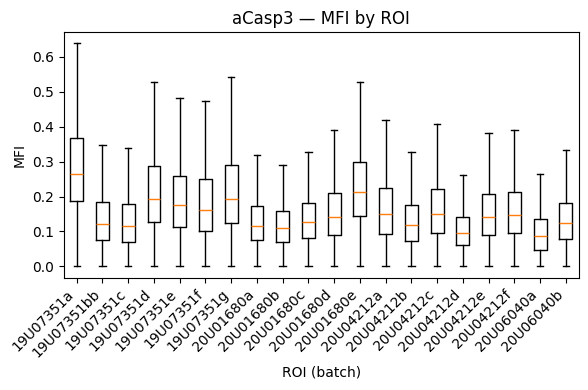

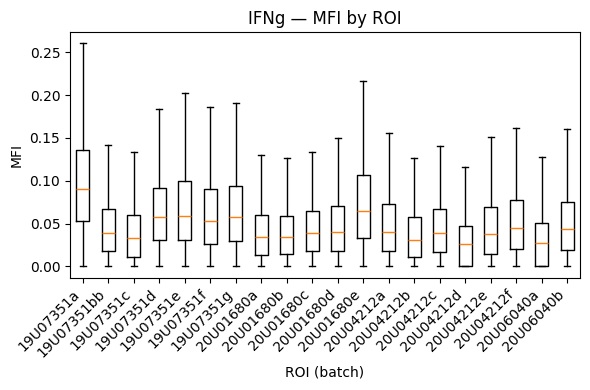

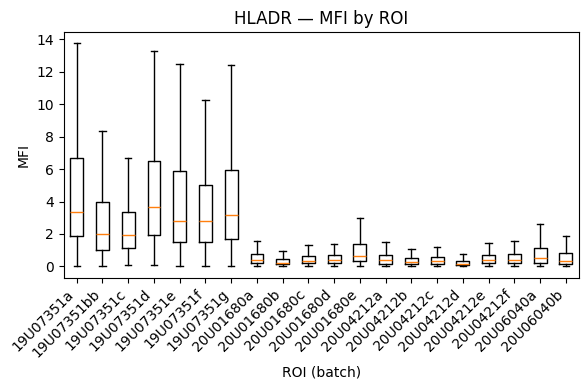

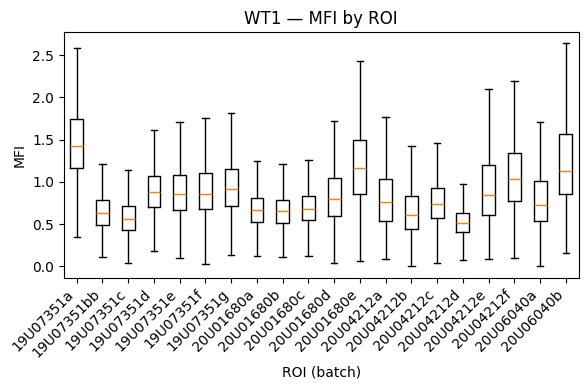

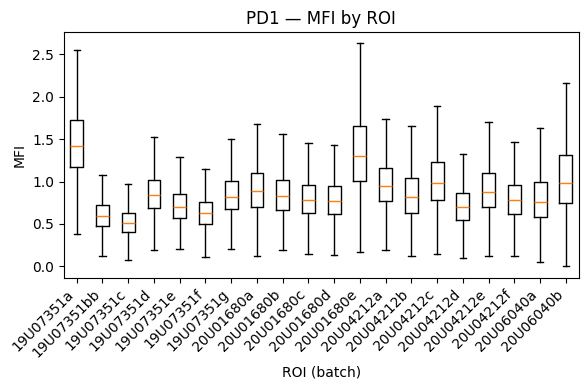

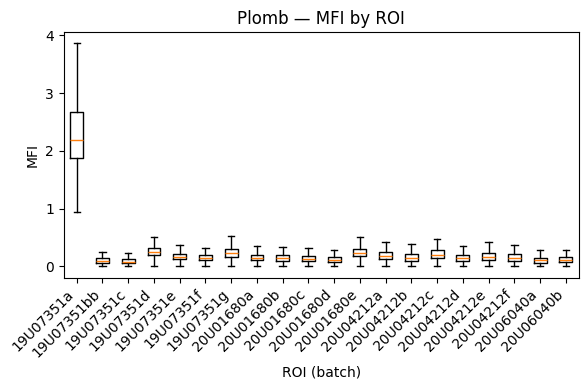

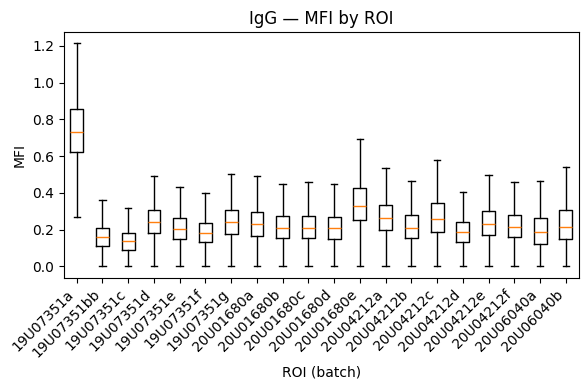

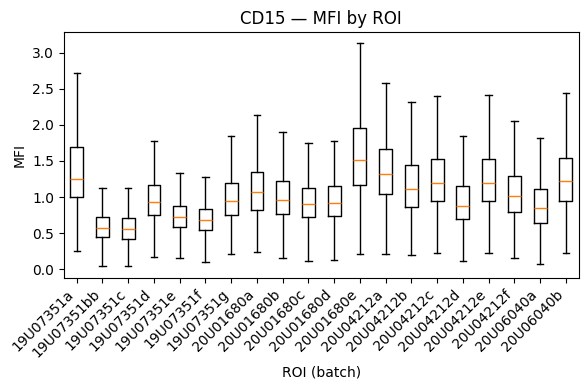

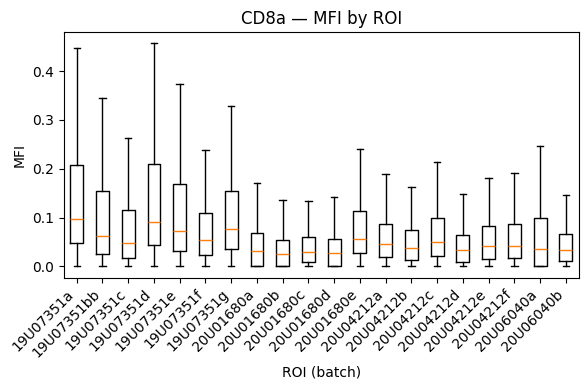

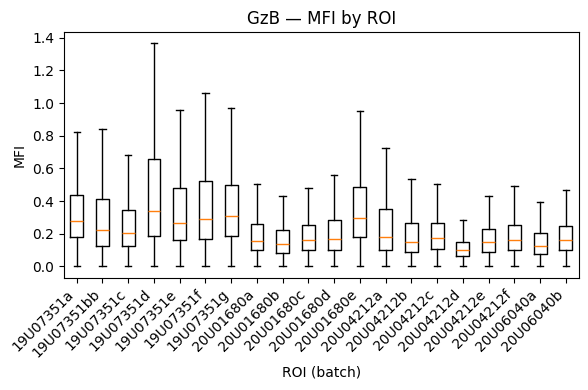

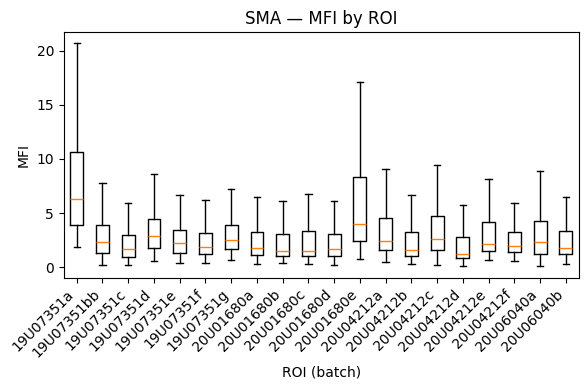

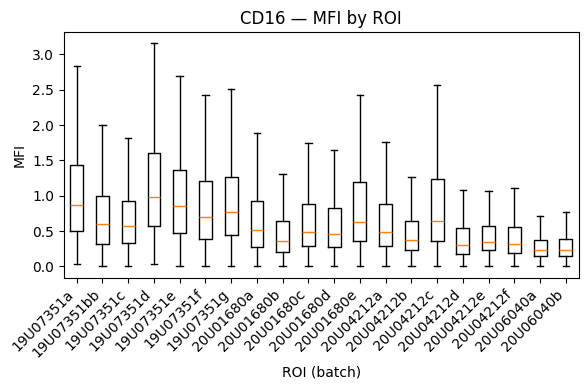

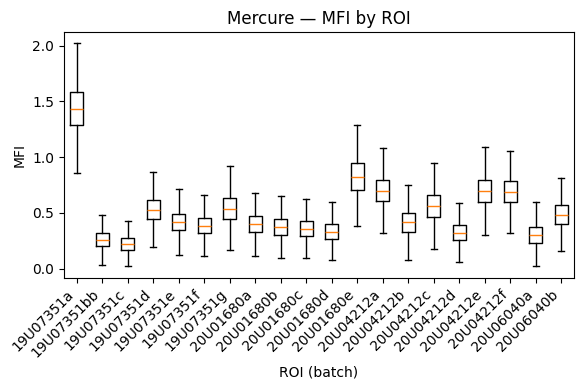

In [8]:

# -------------------------------
# Utility: Benjamini-Hochberg FDR
# -------------------------------
def benjamini_hochberg(pvals, alpha=0.05):
    """
    Perform Benjamini–Hochberg FDR correction.
    Returns:
      - adjusted p-values (q-values)
      - boolean array of rejections at level alpha
    """
    pvals = np.asarray(pvals)
    n = pvals.size
    order = np.argsort(pvals)
    ranks = np.arange(1, n + 1)
    sorted_p = pvals[order]
    q = sorted_p * n / ranks
    # enforce monotonicity
    q = np.minimum.accumulate(q[::-1])[::-1]
    qvals = np.empty_like(q)
    qvals[order.argsort()] = q  # invert sorting
    reject = qvals <= alpha
    return qvals, reject

# ===============================
# 1) Split features / labels
# ===============================
label_col = "ROI"
assert label_col in df_mfi.columns, "ROI column not found in df_mfi."

# Keep only numeric columns as features (exclude ROI)
feature_cols = df_mfi.columns.drop(label_col)
X = df_mfi[feature_cols].apply(pd.to_numeric, errors="coerce")
y = df_mfi[label_col].astype(str).values

# Drop rows with any NaNs in features to avoid issues downstream
mask_valid = X.notnull().all(axis=1)
X = X[mask_valid]
y = y[mask_valid]
print(f"Using {X.shape[0]} cells and {X.shape[1]} markers after dropping NaNs.")

# ===============================
# 2) Standardize features
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# 3) PCA (2D) and UMAP (2D)
# ===============================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

print(f"PCA variance explained (PC1, PC2): {pca.explained_variance_ratio_[0]:.2%}, {pca.explained_variance_ratio_[1]:.2%}")

# ===============================
# 5) ANOVA per marker across batches (ROI)
# ===============================
anova_rows = []
groups = pd.Series(y).unique().tolist()

for col in feature_cols:
    # Build groups of values for this marker by ROI
    samples = [X[col].values[y == g] for g in groups]
    # Keep only groups that have at least 2 observations
    samples = [s for s in samples if len(s) >= 2]
    if len(samples) >= 2:
        F, p = f_oneway(*samples)
    else:
        F, p = np.nan, np.nan
    anova_rows.append({"marker": col, "F": F, "pval": p})

df_anova = pd.DataFrame(anova_rows).sort_values("pval", na_position="last")
# FDR (Benjamini-Hochberg)
qvals, reject = benjamini_hochberg(df_anova["pval"].fillna(1.0).values, alpha=0.05)
df_anova["qval_BH"] = qvals
df_anova["significant_FDR5%"] = reject

# Optionally save
# df_anova.to_csv("anova_by_marker.csv", index=False)

# ===============================
# 6) Plots: PCA and UMAP colored by ROI
# ===============================
def _scatter_2d(ax, emb, labels, title):
    """Simple 2D scatter with one color per label."""
    unique_labels = np.unique(labels)
    for lab in unique_labels:
        sel = labels == lab
        ax.scatter(emb[sel, 0], emb[sel, 1], s=12, alpha=0.8, label=lab)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(title="ROI", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.figure(figsize=(6, 5))
ax = plt.gca()
_scatter_2d(ax, X_umap, y, "UMAP")
plt.tight_layout()
plt.savefig(path_batch_effect+"umap.png")
plt.show()

# ===============================
# 7) Quick boxplots (optional): MFI distribution by ROI for top ANOVA markers
# ===============================
# This helps visually confirm batch-driven shifts for the most significant markers.
top_markers = df_anova.dropna().sort_values("qval_BH")["marker"].tolist()
if top_markers:
    n = len(top_markers)
    for m in top_markers:
        plt.figure(figsize=(6, 4))
        # Build boxplot data in label order
        data = [X[m].values[y == g] for g in groups if np.sum(y == g) > 0]
        plt.boxplot(data, labels=[g for g in groups if np.sum(y == g) > 0], showfliers=False)
        plt.title(f"{m} — MFI by ROI")
        plt.xlabel("ROI (batch)")
        plt.ylabel("MFI")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(path_batch_effect+f"boxplot_{m}.png")
print("✅ Folder with reduction of dimension and ANOVA boxplot: "+path_batch_effect)


## Management of Batch Effect and Outliers


### Arcsinh transformation
The arcsinh transformation with a cofactor is used to stabilize variance and compress the wide dynamic range of fluorescence intensity values, making weak and strong signals more comparable. Unlike a pure logarithmic transform, it behaves linearly near zero, which preserves information from low or even slightly negative values.

In [9]:
cofactor=int(input("Enter the cofactor for the Arcsinh transformation (5):"))

Enter the cofactor for the Arcsinh transformation (5):5


In [10]:
df_mfi=pd.read_csv(path_clust_mfi+"df_mfi_tot_raw.csv")
df_mfi=df_mfi.drop(["area","centroid-0","centroid-1","coord","equivalent_diameter_area"],axis=1)
df_mfi.head()

,label,ROI,80ArAr,127I,131Xe,134Xe,138Ba,CD38,Ki67,Vimentin,...,WT1,ColT4,DNA,PanKerat,CD15,PD1,SMA,Mercure,Plomb,IgG
0,5,19U07351a,12566.373,86.111190,129.72176,61.724876,0.497983,0.373718,0.055599,2.574780,...,1.749396,2.227598,725.97784,5.170626,1.881951,2.162324,17.643002,1.746705,4.809782,0.911882
1,6,19U07351a,12640.579,92.810660,131.89067,62.889145,0.739459,0.338349,0.218134,15.753172,...,2.280322,4.216239,964.25190,18.948042,2.881947,2.931211,6.106355,1.674988,4.824940,1.392733
2,8,19U07351a,12569.162,90.300910,128.45445,62.542603,1.014640,0.503045,0.165579,6.313564,...,1.630679,2.014527,715.59020,4.322050,1.566820,1.706904,7.885904,2.294808,3.812945,0.806452
3,9,19U07351a,12594.119,90.716606,128.66647,63.650314,0.340614,0.096774,0.000000,1.366807,...,1.832697,4.554718,275.66034,2.306403,0.942875,1.025478,8.384796,1.585109,4.481205,1.047839
4,10,19U07351a,12585.801,87.562840,130.45580,60.940643,0.595372,0.251408,0.089641,2.224281,...,2.247639,0.326010,636.64710,3.824432,1.671986,1.151583,2.373060,1.757392,4.269692,0.880910


In [11]:
list_col=[col for col in df_mfi.columns if col!="ROI"]
df_mfi_arcsinh = df_mfi.copy()
df_mfi_arcsinh[list_col] = np.arcsinh(df_mfi[list_col] / cofactor)
df_mfi_arcsinh.to_csv(path_clust_mfi+"df_mfi_tot_arcsinh.csv",index=False)
print("✅ Folder with MFI transformed Arcsinh: "+path_clust_mfi+"df_mfi_tot_arcsinh.csv")
df_mfi_arcsinh.isna().sum().sum()

✅ Folder with MFI transformed Arcsinh: /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/df_mfi_tot_arcsinh.csv


np.int64(0)

### ComBbat algorithm (Combating Batch effect)
The ComBat algorithm aims to reduce batch effect by modeling and adjusting for systematic technical variations across batches while preserving true biological differences.

In [12]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

# Chargement
df_mfi_arcsinh = pd.read_csv(path_clust_mfi + "df_mfi_tot_arcsinh.csv")

# --- 1. Séparation batches / features ---

# Batch = ROI (nom de la biopsie / lame, etc.)
batches = df_mfi_arcsinh["ROI"].astype(str).fillna("NA").copy()

# On ne garde pour ComBat que les colonnes numériques (tous les marqueurs)
features = df_mfi_arcsinh.drop(columns=["ROI"])
features = features.apply(pd.to_numeric, errors="coerce")  # force en numérique

# Optionnel : afficher un résumé
print("Dtypes des features :")
print(features.dtypes.head())
print("Nombre de NaN par colonne (avant ComBat) :")
print(features.isna().sum().head())

# Vérifs minimales
assert batches.nunique() > 1, "Il faut au moins 2 batches (ROI différents) pour appliquer ComBat."
assert len(features) == len(batches), "Incohérence entre le nombre de lignes et le nombre de batches."

# Reset index (important pour AnnData)
features.reset_index(drop=True, inplace=True)
batches.reset_index(drop=True, inplace=True)

# --- 2. Création de l'AnnData ---

adata = ad.AnnData(X=features.to_numpy(dtype=float))
adata.var_names = features.columns.astype(str)
adata.obs = pd.DataFrame({"ROI": batches})
adata.obs.index = features.index.astype(str)

# --- 3. Application de ComBat ---

sc.pp.combat(adata, key="ROI")

# --- 4. Récupération des données corrigées ---

corrected_df = pd.DataFrame(
    adata.X,
    columns=features.columns,
    index=features.index
)

# On remet la colonne ROI
corrected_df["ROI"] = batches.values

# Sauvegarde
out_path = path_clust_mfi + "df_mfi_tot_corrected.csv"
corrected_df.to_csv(out_path, index=False)
print("✅ Folder with MFI corrected by ComBat:", out_path)

# Aperçu
corrected_df.head()


Dtypes des features :
label     float64
80ArAr    float64
127I      float64
131Xe     float64
134Xe     float64
dtype: object
Nombre de NaN par colonne (avant ComBat) :
label     0
80ArAr    0
127I      0
131Xe     0
134Xe     0
dtype: int64


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Folder with MFI corrected by ComBat: /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/df_mfi_tot_corrected.csv


,label,80ArAr,127I,131Xe,134Xe,138Ba,CD38,Ki67,Vimentin,CD14,...,ColT4,DNA,PanKerat,CD15,PD1,SMA,Mercure,Plomb,IgG,ROI
0,1.271128,7.249893,2.217052,3.300661,2.557998,0.092341,0.035694,0.006929,0.390712,0.403925,...,0.266015,4.994867,0.664544,0.256758,0.265633,1.140733,0.188275,0.201760,0.065703,19U07351a
1,1.405316,7.262315,2.286928,3.311898,2.570852,0.154453,0.032268,0.033269,1.634044,0.495636,...,0.497970,5.270255,1.560934,0.362413,0.363323,0.460005,0.168496,0.202572,0.114922,19U07351a
2,1.637615,7.250361,2.261359,3.294008,2.567051,0.224700,0.048204,0.024755,0.899627,0.981192,...,0.238781,4.980884,0.567485,0.221875,0.205065,0.609492,0.336363,0.145636,0.054785,19U07351a
3,1.738762,7.254546,2.265642,3.295126,2.579128,0.051695,0.008835,-0.002086,0.187057,0.122100,...,0.533302,4.055383,0.302715,0.151042,0.111364,0.647171,0.143588,0.183869,0.079721,19U07351a
4,1.831673,7.253152,2.232642,3.304485,2.549203,0.117435,0.023841,0.012447,0.333380,0.203436,...,0.011372,4.867472,0.506654,0.233591,0.128939,0.048170,0.191215,0.172039,0.062500,19U07351a


In [13]:
df_mfi_arcsinh=pd.read_csv(path_clust_mfi+"df_mfi_tot_arcsinh.csv")

# Séparer les features et les batches
features = df_mfi_arcsinh.drop(columns=["ROI"]).copy()
batches = df_mfi_arcsinh["ROI"].astype(str).fillna("NA").copy()

# Vérification minimale
assert batches.nunique() > 1, "At least 2 samples to apply ComBat "
assert len(features) == len(batches), "Number of rows uncorrect"

# Remise à zéro des index (important !)
features.reset_index(drop=True, inplace=True)
batches.reset_index(drop=True, inplace=True)

# Création d'un AnnData
adata = ad.AnnData(X=features.values)
adata.var_names = features.columns
adata.obs = pd.DataFrame({"ROI": batches})
adata.obs.index = features.index.astype(str)


# Application de ComBat
sc.pp.combat(adata, key='ROI')

# Récupération des données corrigées
corrected_df = pd.DataFrame(adata.X, columns=features.columns, index=features.index)
corrected_df["ROI"]=df_mfi["ROI"]
corrected_df.to_csv(path_clust_mfi+"df_mfi_tot_corrected.csv",index=False)
print("✅ Folder with MFI corrected by ComBat: "+path_clust_mfi+"df_mfi_tot_corrected.csv")
corrected_df.head()

/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


✅ Folder with MFI corrected by ComBat: /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/df_mfi_tot_corrected.csv


,label,80ArAr,127I,131Xe,134Xe,138Ba,CD38,Ki67,Vimentin,CD14,...,ColT4,DNA,PanKerat,CD15,PD1,SMA,Mercure,Plomb,IgG,ROI
0,1.271128,7.249893,2.217052,3.300661,2.557998,0.092341,0.035694,0.006929,0.390712,0.403925,...,0.266015,4.994867,0.664544,0.256758,0.265633,1.140733,0.188275,0.201760,0.065703,19U07351a
1,1.405316,7.262315,2.286928,3.311898,2.570852,0.154453,0.032268,0.033269,1.634044,0.495636,...,0.497970,5.270255,1.560934,0.362413,0.363323,0.460005,0.168496,0.202572,0.114922,19U07351a
2,1.637615,7.250361,2.261359,3.294008,2.567051,0.224700,0.048204,0.024755,0.899627,0.981192,...,0.238781,4.980884,0.567485,0.221875,0.205065,0.609492,0.336363,0.145636,0.054785,19U07351a
3,1.738762,7.254546,2.265642,3.295126,2.579128,0.051695,0.008835,-0.002086,0.187057,0.122100,...,0.533302,4.055383,0.302715,0.151042,0.111364,0.647171,0.143588,0.183869,0.079721,19U07351a
4,1.831673,7.253152,2.232642,3.304485,2.549203,0.117435,0.023841,0.012447,0.333380,0.203436,...,0.011372,4.867472,0.506654,0.233591,0.128939,0.048170,0.191215,0.172039,0.062500,19U07351a


## Standardization
Standardization rescales features to have zero mean and unit variance, ensuring that all markers contribute equally regardless of their original scale. This prevents variables with large ranges from dominating distance-based analyses such as PCA, clustering, or UMAP.

In [14]:

# --- Load data ---
df_mfi = pd.read_csv(path_clust_mfi + "df_mfi_tot_raw.csv")
df_mfi=df_mfi.dropna()
df_corrected = pd.read_csv(path_clust_mfi + "df_mfi_tot_corrected.csv")

# --- Basic sanity checks ---
# Ensure the required columns exist
required_meta = ["ROI", "area", "centroid-0", "centroid-1", "coord"]
missing_in_raw = [c for c in required_meta if c not in df_mfi.columns]
assert "ROI" in df_corrected.columns, "Column 'ROI' missing in df_corrected."
for c in ["area", "centroid-0", "centroid-1", "coord"]:
    assert c in df_mfi.columns, f"Column '{c}' missing in df_mfi."

# Optional: enforce identical row counts / alignment assumption
assert len(df_mfi) == len(df_corrected), "df_mfi and df_corrected must have the same number of rows."

# --- Standardize only marker columns (exclude 'ROI' and known metadata if present) ---
exclude_cols = set(required_meta) & set(df_corrected.columns)
marker_cols = [c for c in df_corrected.columns if c not in exclude_cols]

scaler = StandardScaler()
X = df_corrected[marker_cols]
X_std = scaler.fit_transform(X)

# Rebuild the standardized frame with original index for safe alignment
corrected_df_std = pd.DataFrame(X_std, columns=marker_cols, index=df_corrected.index)

# --- Reattach labels/metadata ---
corrected_df_std = (
    corrected_df_std
    .assign(
        ROI=df_corrected["ROI"].values,
        area=df_mfi["area"].values,
        **{
            "centroid-0": df_mfi["centroid-0"].values,
            "centroid-1": df_mfi["centroid-1"].values,
            "coord": df_mfi["coord"].values,
            "Cell_ID": lambda d: d.index.astype(int)
        }
    )
)

# --- Save ---
out_path = path_clust + "mfi_corrected_arcsinh_std.csv"
corrected_df_std.to_csv(out_path, index=False)

# --- Preview ---
print("✅ Folder with MFI corrected by ComBat: "+path_clust_mfi+"df_mfi_corrected_arcsinh_std.csv")
corrected_df_std.head()


✅ Folder with MFI corrected by ComBat: /content/gdrive/MyDrive/these/pipeline/VAA/clustering/MFI/df_mfi_corrected_arcsinh_std.csv


,label,80ArAr,127I,131Xe,134Xe,138Ba,CD38,Ki67,Vimentin,CD14,...,SMA,Mercure,Plomb,IgG,ROI,area,centroid-0,centroid-1,coord,Cell_ID
0,-5.677670,0.641772,-1.627364,5.376977,5.328584,1.148572,-0.097241,-0.153436,0.064278,-0.049376,...,1.712617,1.331406,3.512444,0.661875,19U07351a,38.0,1.473684,174.631579,"169,0;170,0;171,0;172,0;173,0;174,0;175,0;176,...",0
1,-5.539153,0.807803,-0.775340,5.544132,5.510813,2.627281,-0.213822,2.335159,3.370331,0.294091,...,-0.242009,1.024677,3.531368,2.680571,19U07351a,37.0,1.729730,216.945946,"213,0;214,0;215,0;216,0;217,0;218,0;219,0;220,...",1
2,-5.299361,0.648030,-1.087118,5.278011,5.456925,4.299666,0.328469,1.530734,1.417498,2.112538,...,0.187224,3.627974,2.203268,0.214089,19U07351a,30.0,2.233333,182.366667,"180,0;181,0;182,0;183,0;184,0;180,1;181,1;182,...",2
3,-5.194950,0.703966,-1.034885,5.294635,5.628146,0.180905,-1.011266,-1.005055,-0.477245,-1.104832,...,0.295413,0.638396,3.095101,1.236839,19U07351a,31.0,2.709677,13.451613,"12,0;13,0;14,0;11,1;12,1;13,1;14,1;15,1;11,2;1...",3
4,-5.099043,0.685335,-1.437270,5.433859,5.203902,1.745983,-0.500614,0.367953,-0.088167,-0.800222,...,-1.424542,1.376998,2.819140,0.530495,19U07351a,53.0,2.150943,106.679245,"101,0;102,0;103,0;104,0;105,0;106,0;107,0;108,...",4
